<h1><center><font size="6">Modeling and Feature Selection 
Notebook</font></center></h1>

# <a id='0'>Contents</a>

- <a href='#1'>Importing Packages</a>
- <a href='#2'>Baseline Model</a>  
    - <a href='#21'>Logistic Regression</a>
    - <a href='#22'>Random Forest Classifier</a>
    - <a href='#23'>Decision Tree Classifier</a>
    - <a href='#24'>K-Nearest Neighbors</a>
    - <a href='#25'>Gaussian Naive Bayes Classifier</a>
    - <a href='#26'>Linear Discriminant Analysis</a>
    - <a href='#27'>AdaBoost Classifier</a>
    - <a href='#28'>Gradient Boosting Classifier</a>
    - <a href='#29'>XGBoost Classifier</a>
- <a href='#3'>Model with Engineered Features</a>
    - <a href='#31'>Logistic Regression</a>
    - <a href='#32'>Random Forest Classifier</a>
    - <a href='#33'>Decision Tree Classifier</a>
    - <a href='#34'>K-Nearest Neighbors</a>
    - <a href='#35'>Gaussian Naive Bayes Classifier</a>
    - <a href='#36'>Linear Discriminant Analysis</a>
    - <a href='#37'>AdaBoost Classifier</a>
    - <a href='#38'>Gradient Boosting Classifier</a>
    - <a href='#39'>XGBoost Classifier</a>
- <a href='#4'>Feature Selection</a>
    - <a href='#41'>Decision Tree Feature Importance</a>
    - <a href='#42'>Random Forest Feature Importance</a>
    - <a href='#43'>XGBoost Feature Importance</a>
    - <a href='#44'>Recursive Feature Elimination with Cross-Validation</a>
- <a href='#5'>Discussion of Evaluation Metrics</a>


# <a id='1'>Importing Packages</a>

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import Counter
plt.style.use("fivethirtyeight")
import pickle

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%reload_ext autoreload
%autoreload 2
from utils import *

# <a id='2'>Baseline Model</a>

## Importing Pickles

In [3]:
pickle_in = open("../data/training_cleaned.pickle","rb")
train = pickle.load(pickle_in)
pickle_in = open("../data/validate_cleaned.pickle","rb")
validate = pickle.load(pickle_in)

In [4]:
train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1789.20,2,2,1,44,0,0,0,0,0,...,800.13,846.61,981.23,107.92,179.03,107.35,107.35,178.92,33.06,0
1,5725.43,2,3,1,46,-1,-1,-1,0,-1,...,147.68,142.96,30.13,83.84,173.77,35.78,142.96,30.13,941.58,0
2,3578.39,2,2,1,47,-1,-1,-1,-1,-1,...,224.37,-14.17,-14.17,238.54,0.00,224.37,0.00,0.00,0.00,1
3,6083.27,2,2,1,29,0,0,0,0,0,...,2286.70,1556.78,1574.31,79.98,89.21,92.50,60.22,68.03,75.54,0
4,5367.59,2,1,2,33,-2,-2,-2,-2,-2,...,1197.29,994.79,80.91,966.42,1170.67,1197.87,995.08,80.91,6064.12,0


In [5]:
validate.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1073.52,1,2,2,25,0,0,0,0,0,...,450.16,490.81,530.60,53.68,71.57,53.68,53.68,53.68,71.57,0
1,5367.59,2,1,2,26,0,0,0,0,0,...,3634.97,2781.88,2764.81,160.53,151.54,113.11,94.72,95.51,95.51,0
2,2504.88,2,3,1,32,0,0,0,0,0,...,2496.04,2508.85,2512.46,86.99,111.36,107.35,87.24,89.46,91.39,0
3,4651.91,1,3,2,49,0,0,0,0,0,...,604.68,402.07,248.48,57.61,64.70,250.99,0.97,250.88,157.74,0
4,1789.20,2,2,2,36,0,0,0,0,0,...,700.43,726.23,695.60,71.57,53.68,35.78,64.41,0.00,35.78,1


## Preparing Datasets for Modeling

### Identify Feature and Target Vectors

In [6]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]


### Standardize Features for Logistic Regression

In [7]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = X_train[['gender', 'education', 'marriage']]
dum_index = dum_feat.columns
tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
cont_feat = X_train.drop(['gender', 'education', 'marriage'], axis=1)
X_train_dum = cont_feat.join(tr_dum)
X_train_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,paid3,paid4,paid5,paid6,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3
0,1789.20,44,0,0,0,0,0,0,1630.96,1499.56,...,107.35,107.35,178.92,33.06,1,1,0,0,0,0
1,5725.43,46,-1,-1,-1,0,-1,-1,891.16,83.66,...,35.78,142.96,30.13,941.58,1,0,1,0,0,0
2,3578.39,47,-1,-1,-1,-1,-1,-2,238.54,238.54,...,224.37,0.00,0.00,0.00,1,1,0,0,0,0
3,6083.27,29,0,0,0,0,0,0,2830.19,2239.18,...,92.50,60.22,68.03,75.54,1,1,0,0,0,0
4,5367.59,33,-2,-2,-2,-2,-2,-2,872.88,960.69,...,1197.87,995.08,80.91,6064.12,1,0,0,0,1,0


In [8]:
dum_feat2 = X_validate[['gender', 'education', 'marriage']]
dum_index2 = dum_feat2.columns
val_dum = pd.get_dummies(data=dum_feat2, columns=dum_index2, drop_first=True, prefix=['sex', 'edu', 'mar'])
cont_feat2 = X_validate.drop(['gender', 'education', 'marriage'], axis=1)
X_validate_dum = cont_feat2.join(val_dum)
X_validate_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,paid3,paid4,paid5,paid6,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3
0,1073.52,25,0,0,0,0,0,0,317.19,360.06,...,53.68,53.68,53.68,71.57,0,1,0,0,1,0
1,5367.59,26,0,0,0,0,0,0,4892.95,4496.29,...,113.11,94.72,95.51,95.51,1,0,0,0,1,0
2,2504.88,32,0,0,0,0,0,0,2509.24,2471.95,...,107.35,87.24,89.46,91.39,1,0,1,0,0,0
3,4651.91,49,0,0,0,0,0,-1,739.94,678.32,...,250.99,0.97,250.88,157.74,0,0,1,0,1,0
4,1789.20,36,0,0,0,0,0,2,3371.85,1704.57,...,35.78,64.41,0.00,35.78,1,1,0,0,1,0


In [9]:
scaler = StandardScaler().fit(X_train_dum)
X_tr_dum = scaler.transform(X_train_dum)
X_val_dum = scaler.transform(X_validate_dum)

### Standardize for all other classification models

In [10]:
scaler2 = StandardScaler().fit(X_train)
X_tr = scaler2.transform(X_train)
X_val = scaler2.transform(X_validate)

## <a id='21'>Logistic Regression</a>

Training Accuracy:  0.8116666666666666
Validation Accuracy:  0.8115
Training F1 Score:  0.37272006344171293
Validation F1 Score:  0.36065573770491804
Training AUC Score:  0.725932966877932
Validation AUC Score:  0.7268536671329735
Training Recall Score:  0.25236254295532645
Validation Recall Score:  0.24295506473724296
Training Precision Score:  0.7125530624620983
Validation Precision Score:  0.6995614035087719
Training Average Precision Score:  0.5146914414484793
Validation Average Precision Score:  0.4868288430793411

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     16344
           1       0.71      0.25      0.37      4656

    accuracy                           0.81     21000
   macro avg       0.77      0.61      0.63     21000
weighted avg       0.80      0.81      0.77     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.82

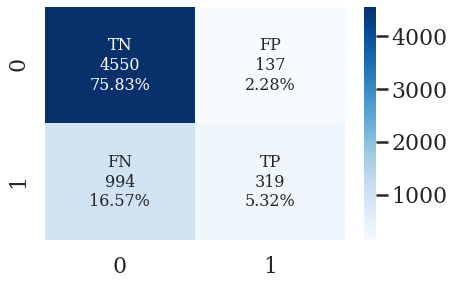

In [11]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr_dum, y_tr)
y_pred_log_tr = logreg.predict(X_tr_dum)
y_pred_log_val = logreg.predict(X_val_dum)
get_metrics(X_tr_dum, y_tr, X_val_dum, y_val, y_pred_log_tr, y_pred_log_val, logreg)

## <a id='22'>Random Forest Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.8161666666666667
Training F1 Score:  0.9988186016539576
Validation F1 Score:  0.46010768477728825
Training AUC Score:  0.9999971484012965
Validation AUC Score:  0.75597555488427
Training Recall Score:  0.9987113402061856
Validation Recall Score:  0.357958872810358
Training Precision Score:  0.9989258861439313
Validation Precision Score:  0.6438356164383562
Training Average Precision Score:  0.999989748216505
Validation Average Precision Score:  0.5128178836633464

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0     

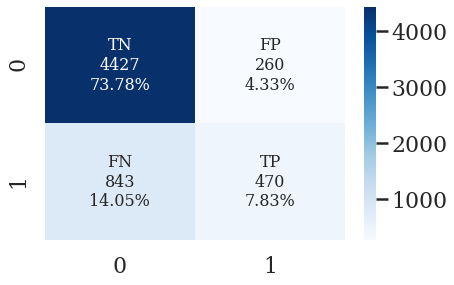

In [12]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

## <a id='13'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7301666666666666
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.39836492010405056
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6140372871049886
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.4082254379284082
Training Precision Score:  1.0
Validation Precision Score:  0.3889695210449927
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.2882872530693953

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83     

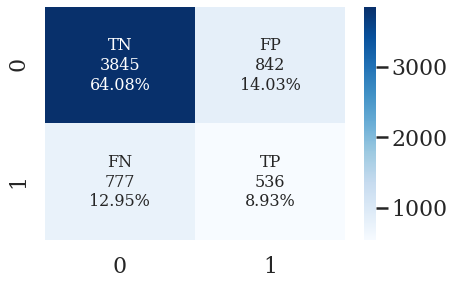

In [13]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

## <a id='14'>K-Nearest Neighbors</a>

Training Accuracy:  0.8436666666666667
Validation Accuracy:  0.798
Training F1 Score:  0.5739130434782609
Validation F1 Score:  0.4470802919708029
Training AUC Score:  0.8809841718663006
Validation AUC Score:  0.7043270500262349
Training Recall Score:  0.47487113402061853
Validation Recall Score:  0.3731911652703732
Training Precision Score:  0.7251557887832076
Validation Precision Score:  0.5574516496018203
Training Average Precision Score:  0.6386904000334307
Validation Average Precision Score:  0.41660496800363034

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.73      0.47      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84  

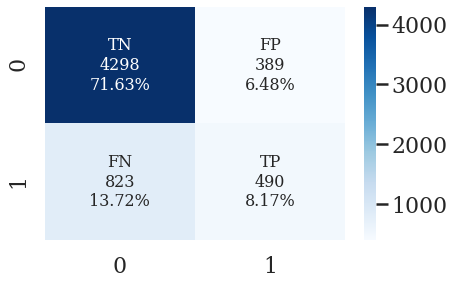

In [14]:
knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

## <a id='15'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.7296190476190476
Validation Accuracy:  0.724
Training F1 Score:  0.509248055315471
Validation F1 Score:  0.4984857662023017
Training AUC Score:  0.7374312830417501
Validation AUC Score:  0.7365532445319174
Training Recall Score:  0.6327319587628866
Validation Recall Score:  0.6268088347296268
Training Precision Score:  0.4260919872722013
Validation Precision Score:  0.41377576671694316
Training Average Precision Score:  0.5011536246357438
Validation Average Precision Score:  0.48098098622250646

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.76      0.81     16344
           1       0.43      0.63      0.51      4656

    accuracy                           0.73     21000
   macro avg       0.65      0.69      0.66     21000
weighted avg       0.78      0.73      0.75     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.88   

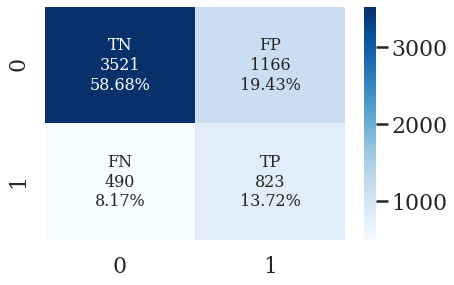

In [15]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

## <a id='17'>Linear Discriminant Analysis</a>

Training Accuracy:  0.8129047619047619
Validation Accuracy:  0.8103333333333333
Training F1 Score:  0.3900015525539512
Validation F1 Score:  0.3677777777777778
Training AUC Score:  0.7198676427176529
Validation AUC Score:  0.7182890368930543
Training Recall Score:  0.2697594501718213
Validation Recall Score:  0.2520944402132521
Training Precision Score:  0.7036414565826331
Validation Precision Score:  0.6796714579055442
Training Average Precision Score:  0.5100386261765641
Validation Average Precision Score:  0.4804758940259745

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     16344
           1       0.70      0.27      0.39      4656

    accuracy                           0.81     21000
   macro avg       0.76      0.62      0.64     21000
weighted avg       0.80      0.81      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

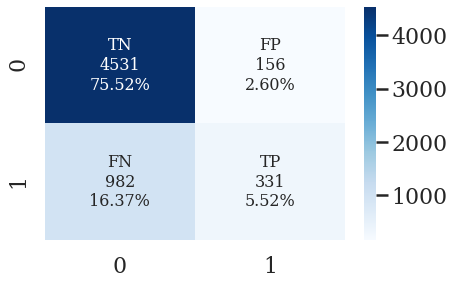

In [16]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_lda_tr, y_pred_lda_val, lda)

## <a id='16'>AdaBoost Classifier</a>

Training Accuracy:  0.820047619047619
Validation Accuracy:  0.8156666666666667
Training F1 Score:  0.45176265776875096
Validation F1 Score:  0.4257528556593977
Training AUC Score:  0.7878643357567455
Validation AUC Score:  0.77515818493602
Training Recall Score:  0.33440721649484534
Validation Recall Score:  0.31226199543031224
Training Precision Score:  0.6960214573088959
Validation Precision Score:  0.6688417618270799
Training Average Precision Score:  0.5573463204971407
Validation Average Precision Score:  0.5234298793408361

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.70      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

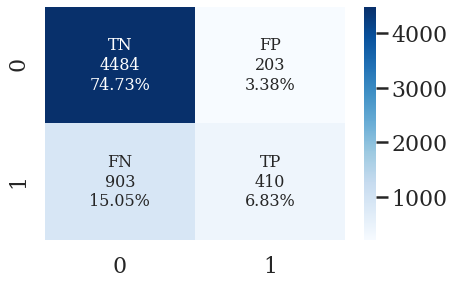

In [17]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

## <a id='18'> Gradient Boosting Classifier</a>

Training Accuracy:  0.8285714285714286
Validation Accuracy:  0.821
Training F1 Score:  0.501799058953778
Validation F1 Score:  0.4688427299703264
Training AUC Score:  0.8092082366680796
Validation AUC Score:  0.7808096026815595
Training Recall Score:  0.3893900343642612
Validation Recall Score:  0.361005331302361
Training Precision Score:  0.7054474708171207
Validation Precision Score:  0.6685472496473907
Training Average Precision Score:  0.6077423441714833
Validation Average Precision Score:  0.5453955242741784

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      

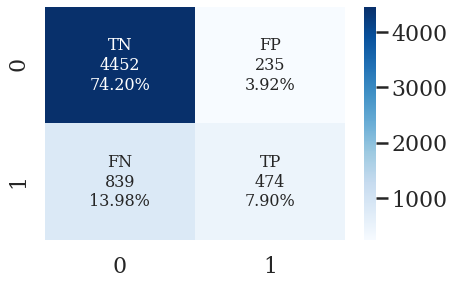

In [18]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbc_tr, y_pred_gbc_val, gbc)

## <a id='19'>XGBoost Classifier</a>

[04:00:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.8923333333333333
Validation Accuracy:  0.8168333333333333
Training F1 Score:  0.7043284948345757
Validation F1 Score:  0.4693384838242395
Training AUC Score:  0.9532041877133048
Validation AUC Score:  0.7651128991712912
Training Recall Score:  0.5783934707903781
Validation Recall Score:  0.37014470677837014
Training Precision Score:  0.9003677699765965
Validation Precision Score:  0.6411609498680739
Training Average Precision Score:  0.874001157693581
Validation Average Precision Score:  0.5187159767657575

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16344
           1

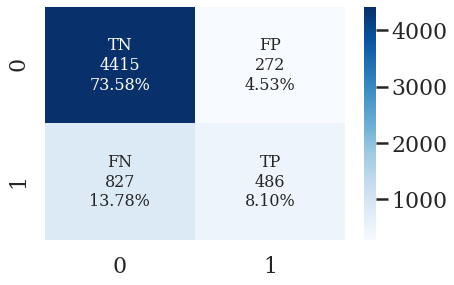

In [19]:
xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgb_tr, y_pred_xgb_val, xgb)

## Evaluation Metrics Summary

In [20]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val), 
                     accuracy(y_val, y_pred_rfc_val), 
                     accuracy(y_val, y_pred_dtc_val), 
                     accuracy(y_val, y_pred_knn_val), 
                     accuracy(y_val, y_pred_gnb_val), 
                     accuracy(y_val, y_pred_lda_val), 
                     accuracy(y_val, y_pred_abc_val), 
                     accuracy(y_val, y_pred_gbc_val),
                     accuracy(y_val, y_pred_xgb_val)],
        'F1 Score': [f1(y_val, y_pred_log_val), 
                     f1(y_val, y_pred_rfc_val), 
                     f1(y_val, y_pred_dtc_val), 
                     f1(y_val, y_pred_knn_val), 
                     f1(y_val, y_pred_gnb_val), 
                     f1(y_val, y_pred_lda_val), 
                     f1(y_val, y_pred_abc_val), 
                     f1(y_val, y_pred_gbc_val),
                     f1(y_val, y_pred_xgb_val)],
        'ROC AUC': [auc(X_val_dum, y_val, logreg),
                      auc(X_val, y_val, rfc),
                      auc(X_val, y_val, dtc),
                      auc(X_val, y_val, knn),
                      auc(X_val, y_val, gnb),
                      auc(X_val, y_val, lda),
                      auc(X_val, y_val, abc),
                      auc(X_val, y_val, gbc),
                      auc(X_val, y_val, xgb)],
        'Recall': [recall(y_val, y_pred_log_val), 
                   recall(y_val, y_pred_rfc_val), 
                   recall(y_val, y_pred_dtc_val), 
                   recall(y_val, y_pred_knn_val), 
                   recall(y_val, y_pred_gnb_val), 
                   recall(y_val, y_pred_lda_val), 
                   recall(y_val, y_pred_abc_val),
                   recall(y_val, y_pred_gbc_val),
                   recall(y_val, y_pred_xgb_val)],
        'Precision': [precision(y_val, y_pred_log_val), 
                      precision(y_val, y_pred_rfc_val), 
                      precision(y_val, y_pred_dtc_val), 
                      precision(y_val, y_pred_knn_val), 
                      precision(y_val, y_pred_gnb_val),
                      precision(y_val, y_pred_lda_val), 
                      precision(y_val, y_pred_abc_val),
                      precision(y_val, y_pred_gbc_val),
                      precision(y_val, y_pred_xgb_val)],
        'PR AUC': [aps(X_val_dum, y_val, logreg),
                   aps(X_val, y_val, rfc),
                   aps(X_val, y_val, dtc),
                   aps(X_val, y_val, knn),
                   aps(X_val, y_val, gnb),
                   aps(X_val, y_val, lda),
                   aps(X_val, y_val, abc),
                   aps(X_val, y_val, gbc),
                   aps(X_val, y_val, xgb)]}
baseline = pd.DataFrame(data=data, index = ['Logistic Regression', 
                                          'Random Forest Classifier', 
                                          'Decision Tree Classifier', 
                                          'K-Nearest Neighbors', 
                                          'Gaussian Naive Bayes', 
                                          'Linear Discriminant Analysis', 
                                          'AdaBoost Classifier', 
                                          'Gradient Boosting Classifier',
                                          'XGBoost Classifier'])

In [21]:
baseline

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression,0.811500,0.360656,0.726854,0.242955,0.699561,0.486829
Random Forest Classifier,0.816167,0.460108,0.755976,0.357959,0.643836,0.512818
Decision Tree Classifier,0.730167,0.398365,0.614037,0.408225,0.388970,0.288287
K-Nearest Neighbors,0.798000,0.447080,0.704327,0.373191,0.557452,0.416605
Gaussian Naive Bayes,0.724000,0.498486,0.736553,0.626809,0.413776,0.480981
Linear Discriminant Analysis,0.810333,0.367778,0.718289,0.252094,0.679671,0.480476
AdaBoost Classifier,0.815667,0.425753,0.775158,0.312262,0.668842,0.523430
Gradient Boosting Classifier,0.821000,0.468843,0.780810,0.361005,0.668547,0.545396
XGBoost Classifier,0.816833,0.469338,0.765113,0.370145,0.641161,0.518716


# <a id='2'>Modeling with Engineered Features</a>

## Importing Pickles

In [22]:
pickle_in = open("../data/training_features.pickle","rb")
train2 = pickle.load(pickle_in)
pickle_in = open("../data/validate_features.pickle","rb")
validate2 = pickle.load(pickle_in)

In [23]:
train2.columns

Index(['limit', 'gender', 'education', 'marriage', 'age', 'behind1', 'behind2',
       'behind3', 'behind4', 'behind5', 'behind6', 'billed1', 'billed2',
       'billed3', 'billed4', 'billed5', 'billed6', 'paid1', 'paid2', 'paid3',
       'paid4', 'paid5', 'paid6', 'default', 'delayed', 'pperb1', 'pperb2',
       'pperb3', 'pperb4', 'pperb5', 'age_bin', 'gen-mar', 'gen-age', 'avail6',
       'avail5', 'avail4', 'avail3', 'avail2', 'avail1', 'avg_av', 'latemths'],
      dtype='object')

In [24]:
validate2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,gen-mar,gen-age,avail6,avail5,avail4,avail3,avail2,avail1,avg_av,latemths
0,1073.52,1,2,2,25,0,0,0,0,0,...,3,2,0.505738,0.542803,0.580669,0.613971,0.664599,0.704533,0.602052,0
1,5367.59,2,1,2,26,0,0,0,0,0,...,4,3,0.484907,0.481726,0.322793,0.222107,0.162326,0.088427,0.293714,0
2,2504.88,2,3,1,32,0,0,0,0,0,...,3,4,-0.003026,-0.001585,0.003529,0.021003,0.013146,-0.001741,0.005221,0
3,4651.91,1,3,2,49,0,0,0,0,0,...,3,3,0.946585,0.913569,0.870015,0.875599,0.854185,0.840938,0.883482,0
4,1789.20,2,2,2,36,0,0,0,0,0,...,4,4,0.611223,0.594104,0.608523,0.152783,0.047300,-0.884557,0.188229,1


## Preparing Datasets for Modeling

In [25]:
X_train2 = train2.drop(["default"], axis=1)
y_tr = train2["default"]
X_validate2 = validate2.drop(["default"], axis=1)
y_val = validate2["default"]

In [26]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = X_train2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index = dum_feat.columns
tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat = X_train2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_train2_dum = cont_feat.join(tr_dum)
X_train2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1789.20,44,0,0,0,0,0,0,1630.96,1499.56,...,0,0,1,0,1,0,0,0,1,0
1,5725.43,46,-1,-1,-1,0,-1,-1,891.16,83.66,...,0,0,1,0,1,0,0,0,1,0
2,3578.39,47,-1,-1,-1,-1,-1,-2,238.54,238.54,...,0,0,1,0,1,0,0,0,1,0
3,6083.27,29,0,0,0,0,0,0,2830.19,2239.18,...,0,0,0,0,1,0,0,1,0,0
4,5367.59,33,-2,-2,-2,-2,-2,-2,872.88,960.69,...,1,0,1,0,0,1,0,0,1,0


In [27]:
dum_feat2 = X_validate2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index2 = dum_feat2.columns
val_dum = pd.get_dummies(data=dum_feat2, columns=dum_index2, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat2 = X_validate2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_validate2_dum = cont_feat2.join(val_dum)
X_validate2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,...,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1073.52,25,0,0,0,0,0,0,317.19,360.06,...,1,0,0,0,1,0,0,0,0,0
1,5367.59,26,0,0,0,0,0,0,4892.95,4496.29,...,1,0,0,0,0,1,0,1,0,0
2,2504.88,32,0,0,0,0,0,0,2509.24,2471.95,...,0,0,1,0,1,0,0,0,1,0
3,4651.91,49,0,0,0,0,0,-1,739.94,678.32,...,1,0,1,0,1,0,0,1,0,0
4,1789.20,36,0,0,0,0,0,2,3371.85,1704.57,...,1,0,1,0,0,1,0,0,1,0


In [28]:
scaler = StandardScaler().fit(X_train2_dum)
X_tr2_dum = scaler.transform(X_train2_dum)
X_val2_dum = scaler.transform(X_validate2_dum)

In [29]:
scaler2 = StandardScaler().fit(X_train2)
X_tr2 = scaler2.transform(X_train2)
X_val2 = scaler2.transform(X_validate2)

## <a id='31'>Logistic Regression</a>

Training Accuracy:  0.8102857142857143
Validation Accuracy:  0.809
Training F1 Score:  0.4204247890602269
Validation F1 Score:  0.3993710691823899
Training AUC Score:  0.760730355665057
Validation AUC Score:  0.7558281718112891
Training Recall Score:  0.31035223367697595
Validation Recall Score:  0.2901751713632902
Training Precision Score:  0.651487826871055
Validation Precision Score:  0.6403361344537815
Training Average Precision Score:  0.5204239720833301
Validation Average Precision Score:  0.5000130015362315

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16344
           1       0.65      0.31      0.42      4656

    accuracy                           0.81     21000
   macro avg       0.74      0.63      0.65     21000
weighted avg       0.79      0.81      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83     

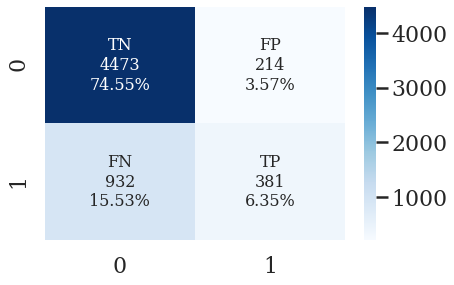

In [30]:
logreg2 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr2_dum, y_tr)
y_pred_log_tr2 = logreg2.predict(X_tr2_dum)
y_pred_log_val2 = logreg2.predict(X_val2_dum)
get_metrics(X_tr2_dum, y_tr, X_val2_dum, y_val, y_pred_log_tr2, y_pred_log_val2, logreg2)

## <a id='32'>Random Forest Classifier</a>

Training Accuracy:  0.9994285714285714
Validation Accuracy:  0.8166666666666667
Training F1 Score:  0.9987110633727175
Validation F1 Score:  0.4685990338164251
Training AUC Score:  0.9999986596171992
Validation AUC Score:  0.7577526827537917
Training Recall Score:  0.9984965635738832
Validation Recall Score:  0.3693830921553694
Training Precision Score:  0.9989256553502364
Validation Precision Score:  0.6406869220607662
Training Average Precision Score:  0.9999950170677467
Validation Average Precision Score:  0.516441154615447

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

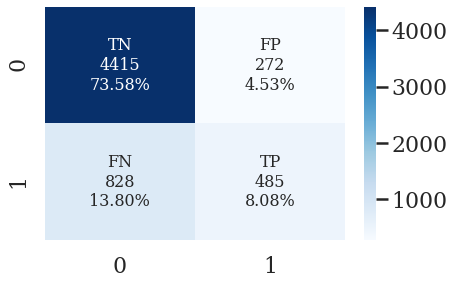

In [31]:
rfc2 = RandomForestClassifier().fit(X_tr2, y_tr)
y_pred_rfc_tr2 = rfc2.predict(X_tr2)
y_pred_rfc_val2 = rfc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_rfc_tr2, y_pred_rfc_val2, rfc2)

## <a id='33'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7231666666666666
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3926873857404022
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6105122804873748
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.408987052551409
Training Precision Score:  1.0
Validation Precision Score:  0.37763713080168776
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.2840244478064121

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      

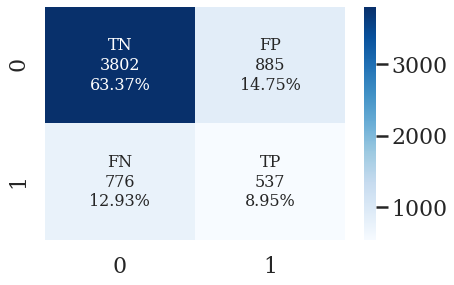

In [32]:
dtc2 = DecisionTreeClassifier().fit(X_tr2, y_tr)
y_pred_dtc_tr2 = dtc2.predict(X_tr2)
y_pred_dtc_val2 = dtc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_dtc_tr2, y_pred_dtc_val2, dtc2)

## <a id='34'>K-Nearest Neighbors</a>

Training Accuracy:  0.8400952380952381
Validation Accuracy:  0.7896666666666666
Training F1 Score:  0.5663739669421487
Validation F1 Score:  0.4253187613843352
Training AUC Score:  0.8802734076042071
Validation AUC Score:  0.6989950164371938
Training Recall Score:  0.47100515463917525
Validation Recall Score:  0.3556740289413557
Training Precision Score:  0.7101683937823834
Validation Precision Score:  0.5288788221970555
Training Average Precision Score:  0.6325856892819814
Validation Average Precision Score:  0.40543887077360036

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.71      0.47      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.73     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

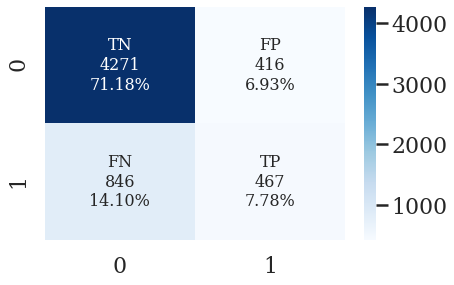

In [33]:
knn2 = KNeighborsClassifier().fit(X_tr2, y_tr)
y_pred_knn_tr2 = knn2.predict(X_tr2)
y_pred_knn_val2 = knn2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_knn_tr2, y_pred_knn_val2, knn2)

## <a id='35'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.2702857142857143
Validation Accuracy:  0.2783333333333333
Training F1 Score:  0.37119409109560936
Validation F1 Score:  0.37409655969933503
Training AUC Score:  0.7314130168305824
Validation AUC Score:  0.7328546118795958
Training Recall Score:  0.9714347079037801
Validation Recall Score:  0.9855293221629855
Training Precision Score:  0.2294308613168307
Validation Precision Score:  0.23086529884032114
Training Average Precision Score:  0.48770555550710337
Validation Average Precision Score:  0.47640316289384194

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.07      0.13     16344
           1       0.23      0.97      0.37      4656

    accuracy                           0.27     21000
   macro avg       0.56      0.52      0.25     21000
weighted avg       0.75      0.27      0.18     21000


Validation Classification Report: 
              precision    recall  f1-score   support

         

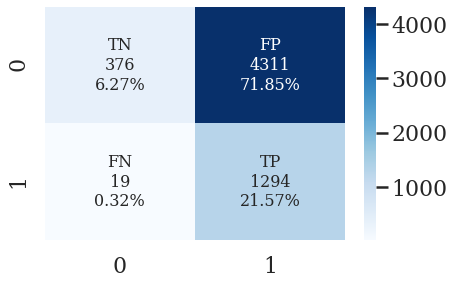

In [34]:
gnb2 = GaussianNB().fit(X_tr2, y_tr)
y_pred_gnb_tr2 = gnb2.predict(X_tr2)
y_pred_gnb_val2 = gnb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gnb_tr2, y_pred_gnb_val2, gnb2)

## <a id='36'>Linear Discriminant Analysis Classifier</a>

Training Accuracy:  0.8104761904761905
Validation Accuracy:  0.809
Training F1 Score:  0.45344685525954415
Validation F1 Score:  0.43768400392541706
Training AUC Score:  0.7550322832511652
Validation AUC Score:  0.7507368747411249
Training Recall Score:  0.3545962199312715
Validation Recall Score:  0.3396801218583397
Training Precision Score:  0.6287128712871287
Validation Precision Score:  0.6151724137931035
Training Average Precision Score:  0.5174630114978035
Validation Average Precision Score:  0.5004744144827257

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     16344
           1       0.63      0.35      0.45      4656

    accuracy                           0.81     21000
   macro avg       0.73      0.65      0.67     21000
weighted avg       0.79      0.81      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84  

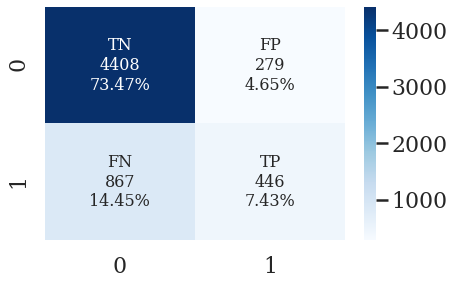

In [35]:
lda2 = LinearDiscriminantAnalysis().fit(X_tr2, y_tr)
y_pred_lda_tr2 = lda2.predict(X_tr2)
y_pred_lda_val2 = lda2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_lda_tr2, y_pred_lda_val2, lda2)

## <a id='37'>AdaBoost Classifier</a>

Training Accuracy:  0.8209047619047619
Validation Accuracy:  0.8188333333333333
Training F1 Score:  0.46735589859793236
Validation F1 Score:  0.4501770359129995
Training AUC Score:  0.795525103109604
Validation AUC Score:  0.7765042945022539
Training Recall Score:  0.3543814432989691
Validation Recall Score:  0.3389185072353389
Training Precision Score:  0.6860706860706861
Validation Precision Score:  0.6701807228915663
Training Average Precision Score:  0.564513246356571
Validation Average Precision Score:  0.5256889284362584

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.69      0.35      0.47      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

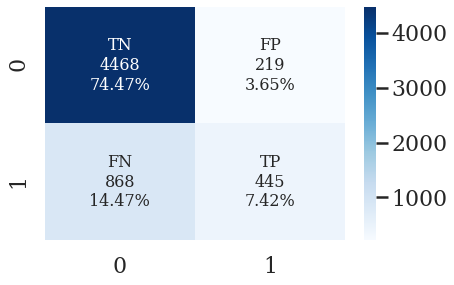

In [36]:
abc2 = AdaBoostClassifier().fit(X_tr2, y_tr)
y_pred_abc_tr2 = abc2.predict(X_tr2)
y_pred_abc_val2 = abc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_abc_tr2, y_pred_abc_val2, abc2)

## <a id='38'>Gradient Boosting Classifier</a>

Training Accuracy:  0.828952380952381
Validation Accuracy:  0.821
Training F1 Score:  0.5012496528742016
Validation F1 Score:  0.4662027833001988
Training AUC Score:  0.8146773467316948
Validation AUC Score:  0.7820943703403509
Training Recall Score:  0.38767182130584193
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7089552238805971
Validation Precision Score:  0.670958512160229
Training Average Precision Score:  0.6121649530334954
Validation Average Precision Score:  0.5411417306141901

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

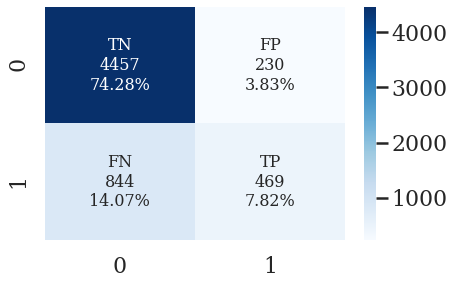

In [37]:
gbc2 = GradientBoostingClassifier().fit(X_tr2, y_tr)
y_pred_gbc_tr2 = gbc2.predict(X_tr2)
y_pred_gbc_val2 = gbc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gbc_tr2, y_pred_gbc_val2, gbc2)

## <a id='39'>XGBoost Classifier</a>

[04:03:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.903952380952381
Validation Accuracy:  0.8128333333333333
Training F1 Score:  0.7408454323525633
Validation F1 Score:  0.4582730342498794
Training AUC Score:  0.9611253309957056
Validation AUC Score:  0.7635266218190971
Training Recall Score:  0.6192010309278351
Validation Recall Score:  0.3617669459253618
Training Precision Score:  0.9219699392388871
Validation Precision Score:  0.625
Training Average Precision Score:  0.897387929019495
Validation Average Precision Score:  0.5252487356090394

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     16344
           1       0.92    

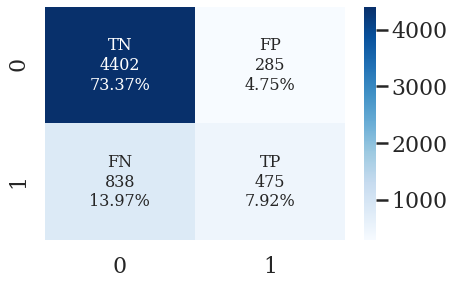

In [38]:
xgb2 = XGBClassifier().fit(X_tr2, y_tr)
y_pred_xgb_tr2 = xgb2.predict(X_tr2)
y_pred_xgb_val2 = xgb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_xgb_tr2, y_pred_xgb_val2, xgb2)

In [39]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val2), 
                     accuracy(y_val, y_pred_rfc_val2), 
                     accuracy(y_val, y_pred_dtc_val2), 
                     accuracy(y_val, y_pred_knn_val2), 
                     accuracy(y_val, y_pred_gnb_val2), 
                     accuracy(y_val, y_pred_lda_val2), 
                     accuracy(y_val, y_pred_abc_val2), 
                     accuracy(y_val, y_pred_gbc_val2),
                     accuracy(y_val, y_pred_xgb_val2)],
        'F1 Score': [f1(y_val, y_pred_log_val2), 
                     f1(y_val, y_pred_rfc_val2), 
                     f1(y_val, y_pred_dtc_val2), 
                     f1(y_val, y_pred_knn_val2), 
                     f1(y_val, y_pred_gnb_val2), 
                     f1(y_val, y_pred_lda_val2), 
                     f1(y_val, y_pred_abc_val2), 
                     f1(y_val, y_pred_gbc_val2),
                     f1(y_val, y_pred_xgb_val2)],
        'ROC AUC': [auc(X_val2_dum, y_val, logreg2),
                    auc(X_val2, y_val, rfc2),
                    auc(X_val2, y_val, dtc2),
                    auc(X_val2, y_val, knn2),
                    auc(X_val2, y_val, gnb2),
                    auc(X_val2, y_val, lda2),
                    auc(X_val2, y_val, abc2),
                    auc(X_val2, y_val, gbc2),
                    auc(X_val2, y_val, xgb2)],
        'Recall': [recall(y_val, y_pred_log_val2), 
                   recall(y_val, y_pred_rfc_val2), 
                   recall(y_val, y_pred_dtc_val2), 
                   recall(y_val, y_pred_knn_val2), 
                   recall(y_val, y_pred_gnb_val2), 
                   recall(y_val, y_pred_lda_val2), 
                   recall(y_val, y_pred_abc_val2),
                   recall(y_val, y_pred_gbc_val2),
                   recall(y_val, y_pred_xgb_val2)],
        'Precision': [precision(y_val, y_pred_log_val2), 
                      precision(y_val, y_pred_rfc_val2), 
                      precision(y_val, y_pred_dtc_val2), 
                      precision(y_val, y_pred_knn_val2), 
                      precision(y_val, y_pred_gnb_val2),
                      precision(y_val, y_pred_lda_val2), 
                      precision(y_val, y_pred_abc_val2),
                      precision(y_val, y_pred_gbc_val2),
                      precision(y_val, y_pred_xgb_val2)],
        'PR AUC': [aps(X_val2_dum, y_val, logreg2),
                   aps(X_val2, y_val, rfc2),
                   aps(X_val2, y_val, dtc2),
                   aps(X_val2, y_val, knn2),
                   aps(X_val2, y_val, gnb2),
                   aps(X_val2, y_val, lda2),
                   aps(X_val2, y_val, abc2),
                   aps(X_val2, y_val, gbc2),
                   aps(X_val2, y_val, xgb2)]}
features_model = pd.DataFrame(data=data, index = ['Logistic Regression 2', 
                                          'Random Forest Classifier 2', 
                                          'Decision Tree Classifier 2', 
                                          'K-Nearest Neighbors 2', 
                                          'Gaussian Naive Bayes 2', 
                                          'Linear Discriminant Analysis 2', 
                                          'AdaBoost Classifier 2', 
                                          'Gradient Boosting Classifier 2',
                                          'XGBoost Classifier 2'])

In [40]:
features_model

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression 2,0.809000,0.399371,0.755828,0.290175,0.640336,0.500013
Random Forest Classifier 2,0.816667,0.468599,0.757753,0.369383,0.640687,0.516441
Decision Tree Classifier 2,0.723167,0.392687,0.610512,0.408987,0.377637,0.284024
K-Nearest Neighbors 2,0.789667,0.425319,0.698995,0.355674,0.528879,0.405439
Gaussian Naive Bayes 2,0.278333,0.374097,0.732855,0.985529,0.230865,0.476403
Linear Discriminant Analysis 2,0.809000,0.437684,0.750737,0.339680,0.615172,0.500474
AdaBoost Classifier 2,0.818833,0.450177,0.776504,0.338919,0.670181,0.525689
Gradient Boosting Classifier 2,0.821000,0.466203,0.782094,0.357197,0.670959,0.541142
XGBoost Classifier 2,0.812833,0.458273,0.763527,0.361767,0.625000,0.525249


# <a id='5'>Discussion of Evaluation Metrics</a>

In [80]:
metrics = pd.concat([baseline, features_model])
met = metrics.sort_index(ascending=True)
met

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
AdaBoost Classifier,0.815667,0.425753,0.775158,0.312262,0.668842,0.523430
AdaBoost Classifier 2,0.818833,0.450177,0.776504,0.338919,0.670181,0.525689
Decision Tree Classifier,0.730167,0.398365,0.614037,0.408225,0.388970,0.288287
Decision Tree Classifier 2,0.723167,0.392687,0.610512,0.408987,0.377637,0.284024
Gaussian Naive Bayes,0.724000,0.498486,0.736553,0.626809,0.413776,0.480981
Gaussian Naive Bayes 2,0.278333,0.374097,0.732855,0.985529,0.230865,0.476403
Gradient Boosting Classifier,0.821000,0.468843,0.780810,0.361005,0.668547,0.545396
Gradient Boosting Classifier 2,0.821000,0.466203,0.782094,0.357197,0.670959,0.541142
K-Nearest Neighbors,0.798000,0.447080,0.704327,0.373191,0.557452,0.416605
K-Nearest Neighbors 2,0.789667,0.425319,0.698995,0.355674,0.528879,0.405439


# <a id='4'> Feature Selection</a>

## <a id='41'>Decision Tree (CART) Feature Importance</a>

In [78]:
# importances = dtc2.feature_importances_
# features = X_train2.columns
# indices = np.argsort(importances)
# sns.set_theme(style="darkgrid", font='serif', context='poster')
# plt.figure(figsize=(14,16))
# plt.title('Decision Tree Feature Importances')
# plt.barh(range(len(indices)), importances[indices])
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
# plt.savefig('../images/dtc_feature_importance.png')

<img src="../images/dtc_feature_importance.png">

## <a id='42'>Random Forest Feature Importance</a>

In [76]:
# importances = rfc2.feature_importances_
# features = X_train2.columns
# indices = np.argsort(importances)
# sns.set_theme(style="darkgrid", font='serif', context='poster')
# plt.figure(figsize=(14,16))
# plt.title('Random Forest Feature Importances')
# plt.barh(range(len(indices)), importances[indices])
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')
# plt.savefig('../images/rf_feature_importance.png')

<img src="../images/rf_feature_importance.png">

## <a id='43'>XGBoost Feature Importance</a>

In [63]:
# plot_feature_importances(X_train2, xgb2)
# plt.title("XGBoost Feature Importance", size=16)
# plt.savefig('../images/xgb_feature_importance.png')

<img src="../images/xgb_feature_importance.png">

## <a id='39'>Recursive Feature Elimination with Cross-Validation</a>

Feature Ranking For Non-Discretised: [ 1 25 19 24 17  1 22  2 14 18  6 12 13  8 23 32 11  5  1 30 27 35 16  1
 26 21 20 36 28 29  7 34 10  9 31 15  3  4 33  1]
Optimal number of features : 5


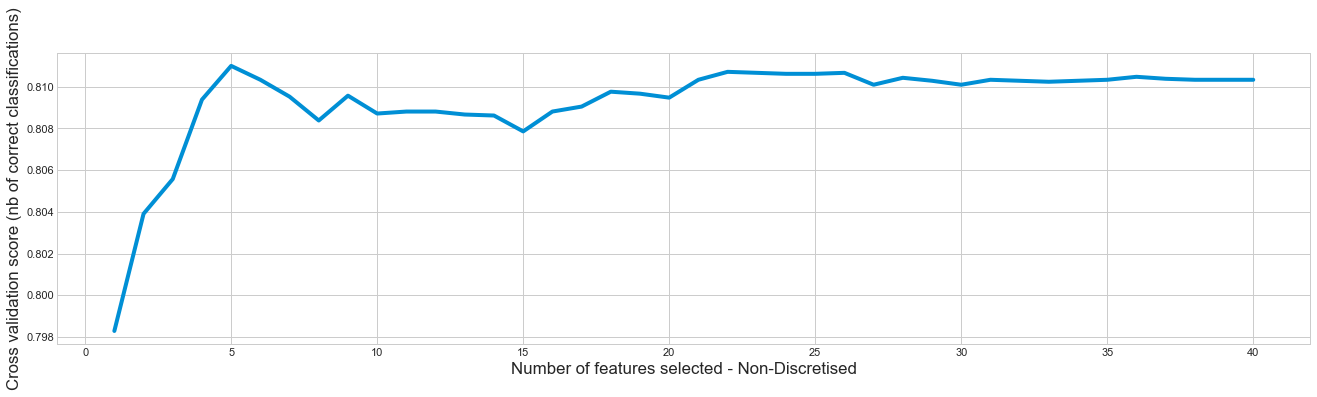

In [59]:
rfe = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1).fit(X_tr2, y_tr)
print("Feature Ranking For Non-Discretised: %s" % rfe.ranking_)
print("Optimal number of features : %d" % rfe.n_features_)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_);

In [64]:
selected = X_train2.columns[rfe.support_]
print(selected)

Index(['limit', 'behind1', 'paid2', 'delayed', 'latemths'], dtype='object')


# New Baseline Model

## Importing and Preparing Data

In [2]:
pickle_in = open("../data/training_model.pickle","rb")
train3 = pickle.load(pickle_in)
pickle_in = open("../data/validate_model.pickle","rb")
validate3 = pickle.load(pickle_in)

In [14]:
train3.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail2,avail1,avg_av,delayed,latemths,pperb1,pperb2,pperb3,pperb4,pperb5
0,1790.80,2,2,1,44,0,0,0,0,0,...,0.161883,0.088441,0.344577,0,0,0.071970,0.140130,0.134170,0.126804,0.182342
1,5730.56,2,3,1,46,-1,-1,-1,0,-1,...,0.985387,0.844350,0.957227,0,0,1.002150,1.000000,0.242338,1.000000,1.000000
2,3581.60,2,2,1,47,-1,-1,-1,-1,-1,...,0.933340,0.933340,0.968649,0,0,1.000000,0.000000,1.000000,-0.000000,-0.000000
3,6088.72,2,2,1,29,0,0,0,0,0,...,0.631913,0.534759,0.650603,0,0,0.035718,0.039374,0.040450,0.038686,0.043212
4,5372.40,2,1,2,33,-2,-2,-2,-2,-2,...,0.821020,0.837380,0.836154,0,0,1.005959,1.000401,1.000476,1.000291,1.000000


In [3]:
X_train3 = train3.drop(["default"], axis=1)
y_tr = train3["default"]
X_validate3 = validate3.drop(["default"], axis=1)
y_val = validate3["default"]

In [4]:
scaler3 = StandardScaler().fit(X_train3)
X_tr3 = scaler3.transform(X_train3)
X_val3 = scaler3.transform(X_validate3)

## Logistic Regression

Training Accuracy:  0.8106666666666666
Validation Accuracy:  0.8076666666666666
Training F1 Score:  0.41769185705916817
Validation F1 Score:  0.3932702418506835
Training AUC Score:  0.7582970746644734
Validation AUC Score:  0.7550046465479293
Training Recall Score:  0.30627147766323026
Validation Recall Score:  0.28484386900228487
Training Precision Score:  0.6565377532228361
Validation Precision Score:  0.634974533106961
Training Average Precision Score:  0.5198632316180285
Validation Average Precision Score:  0.4986698554008637

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16344
           1       0.66      0.31      0.42      4656

    accuracy                           0.81     21000
   macro avg       0.74      0.63      0.65     21000
weighted avg       0.79      0.81      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

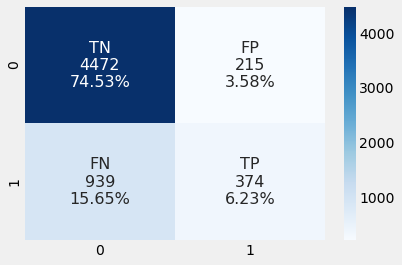

In [5]:
logreg3 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr3, y_tr)
y_pred_log_tr3 = logreg3.predict(X_tr3)
y_pred_log_val3 = logreg3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_log_tr3, y_pred_log_val3, logreg3)

## Random Forest Classifier

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.8146666666666667
Training F1 Score:  0.9988183478354281
Validation F1 Score:  0.45543584720861896
Training AUC Score:  0.9999962022487312
Validation AUC Score:  0.7554038970554423
Training Recall Score:  0.9984965635738832
Validation Recall Score:  0.3541507996953541
Training Precision Score:  0.9991403395658714
Validation Precision Score:  0.6378600823045267
Training Average Precision Score:  0.9999868105704354
Validation Average Precision Score:  0.5107532807662893

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

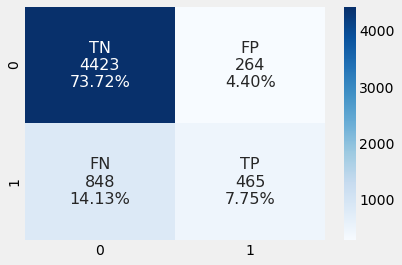

In [6]:
rfc3 = RandomForestClassifier().fit(X_tr3, y_tr)
y_pred_rfc_tr3 = rfc3.predict(X_tr3)
y_pred_rfc_val3 = rfc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_rfc_tr3, y_pred_rfc_val3, rfc3)

## Decision Tree Classifier

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7216666666666667
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.38557763061074324
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6059859789461574
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.3990860624523991
Training Precision Score:  1.0
Validation Precision Score:  0.37295373665480425
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.28057594832841815

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83   

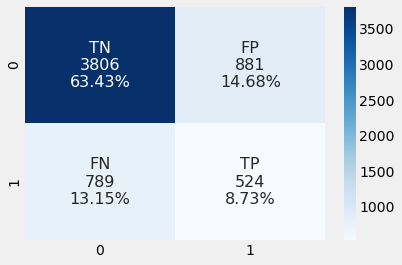

In [7]:
dtc3 = DecisionTreeClassifier().fit(X_tr3, y_tr)
y_pred_dtc_tr3 = dtc3.predict(X_tr3)
y_pred_dtc_val3 = dtc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_dtc_tr3, y_pred_dtc_val3, dtc3)

## Adaboost Classifier

Training Accuracy:  0.8209047619047619
Validation Accuracy:  0.8188333333333333
Training F1 Score:  0.46735589859793236
Validation F1 Score:  0.4501770359129995
Training AUC Score:  0.7955235524706776
Validation AUC Score:  0.7765012070949919
Training Recall Score:  0.3543814432989691
Validation Recall Score:  0.3389185072353389
Training Precision Score:  0.6860706860706861
Validation Precision Score:  0.6701807228915663
Training Average Precision Score:  0.5645111486632847
Validation Average Precision Score:  0.5256890405633987

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.69      0.35      0.47      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

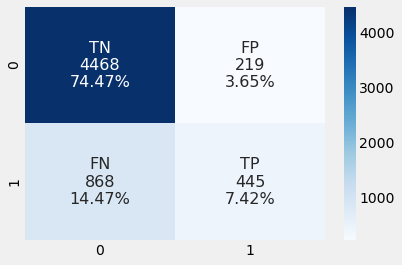

In [8]:
abc3 = AdaBoostClassifier().fit(X_tr3, y_tr)
y_pred_abc_tr3 = abc3.predict(X_tr3)
y_pred_abc_val3 = abc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_abc_tr3, y_pred_abc_val3, abc3)

## Gradient Boosting Classifier

Training Accuracy:  0.8288095238095238
Validation Accuracy:  0.82
Training F1 Score:  0.5014561087227846
Validation F1 Score:  0.46322067594433397
Training AUC Score:  0.8150839098030658
Validation AUC Score:  0.7813121188372305
Training Recall Score:  0.38831615120274915
Validation Recall Score:  0.3549124143183549
Training Precision Score:  0.7076320939334638
Validation Precision Score:  0.6666666666666666
Training Average Precision Score:  0.6122545155470038
Validation Average Precision Score:  0.5425747828788814

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84   

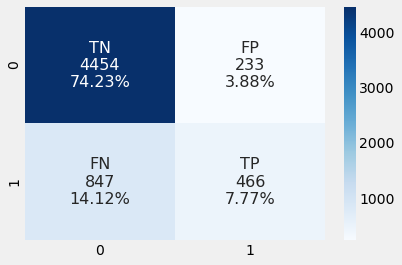

In [9]:
gbc3 = GradientBoostingClassifier().fit(X_tr3, y_tr)
y_pred_gbc_tr3 = gbc3.predict(X_tr3)
y_pred_gbc_val3 = gbc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gbc_tr3, y_pred_gbc_val3, gbc3)

## XGBoost Classifier

[06:40:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.9033333333333333
Validation Accuracy:  0.8125
Training F1 Score:  0.738940329218107
Validation F1 Score:  0.45148707947342764
Training AUC Score:  0.9616740469194953
Validation AUC Score:  0.7616216102908809
Training Recall Score:  0.617053264604811
Validation Recall Score:  0.3526275704493526
Training Precision Score:  0.9208333333333333
Validation Precision Score:  0.6273712737127372
Training Average Precision Score:  0.8968574652494508
Validation Average Precision Score:  0.5156839076040725

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     16344
           1       0.92  

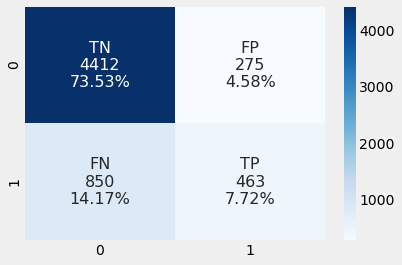

In [10]:
xgb3 = XGBClassifier().fit(X_tr3, y_tr)
y_pred_xgb_tr3 = xgb3.predict(X_tr3)
y_pred_xgb_val3 = xgb3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_xgb_tr3, y_pred_xgb_val3, xgb3)

## Evaluation Metrics

In [11]:
data = {'Accuracy': [accuracy(y_val, y_pred_log_val3), 
                     accuracy(y_val, y_pred_rfc_val3), 
                     accuracy(y_val, y_pred_dtc_val3), 
                     accuracy(y_val, y_pred_abc_val3), 
                     accuracy(y_val, y_pred_gbc_val3),
                     accuracy(y_val, y_pred_xgb_val3)],
        'F1 Score': [f1(y_val, y_pred_log_val3), 
                     f1(y_val, y_pred_rfc_val3), 
                     f1(y_val, y_pred_dtc_val3), 
                     f1(y_val, y_pred_abc_val3), 
                     f1(y_val, y_pred_gbc_val3),
                     f1(y_val, y_pred_xgb_val3)],
        'ROC AUC': [auc(X_val3, y_val, logreg3),
                    auc(X_val3, y_val, rfc3),
                    auc(X_val3, y_val, dtc3),
                    auc(X_val3, y_val, abc3),
                    auc(X_val3, y_val, gbc3),
                    auc(X_val3, y_val, xgb3)],
        'Recall': [recall(y_val, y_pred_log_val3), 
                   recall(y_val, y_pred_rfc_val3), 
                   recall(y_val, y_pred_dtc_val3), 
                   recall(y_val, y_pred_abc_val3),
                   recall(y_val, y_pred_gbc_val3),
                   recall(y_val, y_pred_xgb_val3)],
        'Precision': [precision(y_val, y_pred_log_val3), 
                      precision(y_val, y_pred_rfc_val3), 
                      precision(y_val, y_pred_dtc_val3), 
                      precision(y_val, y_pred_abc_val3),
                      precision(y_val, y_pred_gbc_val3),
                      precision(y_val, y_pred_xgb_val3)],
        'PR AUC': [aps(X_val3, y_val, logreg3),
                   aps(X_val3, y_val, rfc3),
                   aps(X_val3, y_val, dtc3),
                   aps(X_val3, y_val, abc3),
                   aps(X_val3, y_val, gbc3),
                   aps(X_val3, y_val, xgb3)]}
new_baseline = pd.DataFrame(data=data, index = ['Logistic Regression 3', 
                                          'Random Forest Classifier 3', 
                                          'Decision Tree Classifier 3', 
                                          'AdaBoost Classifier 3', 
                                          'Gradient Boosting Classifier 3',
                                          'XGBoost Classifier 3'])
                                    

In [12]:
new_baseline

,Accuracy,F1 Score,ROC AUC,Recall,Precision,PR AUC
Logistic Regression 3,0.807667,0.393270,0.755005,0.284844,0.634975,0.498670
Random Forest Classifier 3,0.814667,0.455436,0.755404,0.354151,0.637860,0.510753
Decision Tree Classifier 3,0.721667,0.385578,0.605986,0.399086,0.372954,0.280576
AdaBoost Classifier 3,0.818833,0.450177,0.776501,0.338919,0.670181,0.525689
Gradient Boosting Classifier 3,0.820000,0.463221,0.781312,0.354912,0.666667,0.542575
XGBoost Classifier 3,0.812500,0.451487,0.761622,0.352628,0.627371,0.515684


In [13]:
new_baseline.to_csv("../data/new_baseline.csv")